# VCF - Parametric low-pass filter

A low pass filter where the following parameters are independently controllable:

- Cutoff frequency
- Resonance

In [1]:
from numpy import *
from matplotlib.pyplot import *
from scipy import signal
import scipy.io.wavfile

In [26]:
class Simulator(object):
    def __init__(self, amplitude=2**15-1, yrange=[-50, 10]):
        self.amplitude = amplitude
        self.yrange = yrange
        
        self.fig, self.ax1 = subplots(1, 1, figsize=[8, 4])
        
        # Load/generate data files
        self.sample_rate_Hz = 44100
        fs, x = scipy.io.wavfile.read("../app/sound/prbs20.wav")
        assert(fs == self.sample_rate_Hz)
        self.x_prbs20 = self.amplitude * x/(2**15)
        
        t = arange(len(self.x_prbs20)) / self.sample_rate_Hz
        self.x_chirp = self.amplitude * signal.chirp(t, f0=20, f1=20e3, t1=max(t), method="linear")
    
    def vcf(self, x, cutoff, resonance):
        # Example filter
        b, a = signal.cheby1(2, 10, 1000 * 2/self.sample_rate_Hz, btype="low")
        return signal.lfilter(b, a, x)
    
    def simulate_chirp(self, cutoff, resonance):
        y = self.vcf(self.x_chirp, cutoff, resonance)
        
        f = linspace(20, 20e3, len(y))
        #H = y
        H = 1/self.amplitude * signal.hilbert(y)

        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
        return 
    
    def simulate_prbs(self, cutoff, resonance, h_length=None):
        x = self.x_prbs20
        y = self.vcf(x, cutoff, resonance)
        
        if h_length is None:
            h_length = int(30/cutoff)

        t, h, f, H = self.analyze_prbs(x, y, h_length)
        label = "cutoff={:.0f}, resonance={:.0f}".format(cutoff, resonance)
        self.plot_frequency_response(f, H, label=label)
    
    def analyze_prbs(self, x, y, h_length):
        # Estimate impulse response using a pseudo-random bit sequence.
        h = signal.correlate(y, x, "full")
        h = h[len(h)//2:]

        # Limit the impulse response length to lower the noise
        h = h[0:h_length]
        t = arange(h_length)/self.sample_rate_Hz

        # Estimate frequency response
        H = fft.fft(h)
        H = H[0:len(H)//2] 
        H /= max(abs(H))
        f = linspace(0.01, self.sample_rate_Hz/2, len(H))

        return t, h, f, H

    def plot_frequency_response(self, f, H, label=None):
        self.ax1.semilogx(f, 20*ma.log10(abs(H)), label=label)

    def show(self):
        # Frequency response graph
        self.ax1.grid(True, "both", "both")
        self.ax1.legend()
        self.ax1.set_xlim(20, 20e3)
        self.ax1.set_ylim(*self.yrange)
        
        self.fig.tight_layout()
        #self.fig.show()


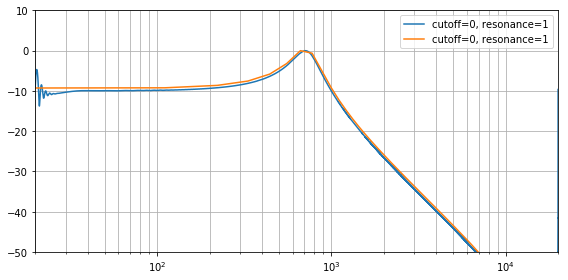

In [27]:
s = Simulator()
s.simulate_chirp(0.01, 1)
s.simulate_prbs(0.01, 1, h_length=400)
s.show()

# Zavalishin 2015 The Art of VA Filter Design

Ladder filter:
- Four single-pole filter, page 48.
- Feedback, page 63.

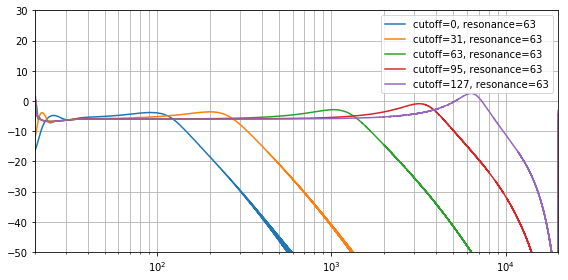

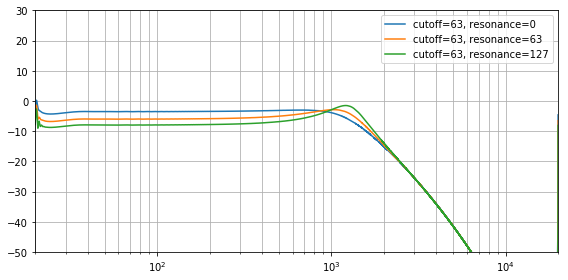

In [28]:
class Zavalishin(Simulator):
    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.01
        a = (0.9-b) / (127*127*127)
        return a*value*value*value + b

    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0.5
        a = (1.5-b) / 127
        return a*value + b

    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
        g = self.map_cutoff(cutoff)
        k = self.map_resonance(resonance)
        G = g/(1+g)

        w1 = [0, 0, 0, 0] # Delayed sum of y[n] and x[n]*G
        y1 = 0 # Delayed output
        for n in range(1, len(y)):
            u = x[n] - y1*k

            # 1
            x_ = u
            v  = (x_-w1[0]) * G
            y_ = v + w1[0]
            w1[0] = y_ + v

            # 2
            x_ = y_
            v  = (x_-w1[1]) * G
            y_ = v + w1[1]
            w1[1] = y_ + v

            # 3
            x_ = y_
            v  = (x_-w1[2]) * G
            y_ = v + w1[2]
            w1[2] = y_ + v

            # 3
            x_ = y_
            v  = (x_-w1[3]) * G
            y_ = v + w1[3]
            w1[3] = y_ + v

            y[n] = y_
            y1 = y_

        return y
    
# Sweep cutoff
s = Zavalishin(yrange=[-50, 30])
for cutoff in [0, 31, 63, 95, 127]:
    s.simulate_chirp(cutoff, 63)
s.show()

# Sweep resonance
s = Zavalishin(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()

# Valimaki 2006 Oscillator and Filter Algorithms for Virtual Analog Synthesis

- Page 27.
- Subfilters designed from Zavalishin 2015 The Art of VA Filter Design

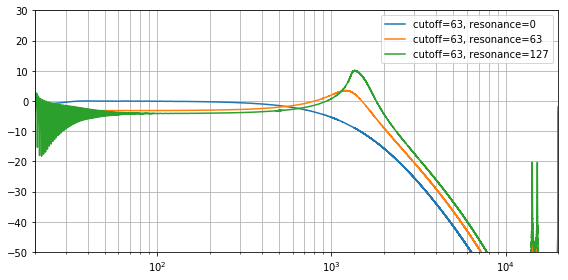

In [38]:
class Valimaki(Simulator):
    def map_resonance(self, value):
        assert(0 <= value <= 127)
        b = 0
        a = (0.8-b) / 127
        return a*value + b

    def map_cutoff(self, value):
        assert(0 <= value <= 127)
        b = 0.01
        a = (0.9-b) / (127*127*127)
        return a*value*value*value + b
    
    def saturate(self, x):
        headroom = 10
        A = headroom * self.amplitude
        return A * tanh(x/(A))
    
    def vcf(self, x, cutoff, resonance):
        y = zeros(len(x))
    
        # TODO: Add mapping from MIDI input to cutoff an resonance
        g = self.map_cutoff(cutoff)
        G_res = self.map_resonance(resonance)

        G = g/(1+g)
        G_comp = 0.5

        w1 = [0, 0, 0, 0] # Delayed sum of y[n] and x[n]*G
        y1 = 0 # Delayed output
        for n in range(1, len(y)):
            # Feedback
            x_ = x[n]
            y_ = x_ - (4*G_res * (y1 - x_*G_comp))

            # Saturate before first filter
            x_ = y_
            y_ = self.saturate(x_)

            # 1
            x_ = y_
            v  = (x_-w1[0]) * G
            y_ = v + w1[0]
            w1[0] = y_ + v

            # 2
            x_ = y_
            v  = (x_-w1[1]) * G
            y_ = v + w1[1]
            w1[1] = y_ + v

            # 3
            x_ = y_
            v  = (x_-w1[2]) * G
            y_ = v + w1[2]
            w1[2] = y_ + v

            # 3
            x_ = y_
            v  = (x_-w1[3]) * G
            y_ = v + w1[3]
            w1[3] = y_ + v

            y[n] = y_
            y1 = y_
        return y

# Sweep cutoff
#s = Valimaki(yrange=[-50, 30])
#for cutoff in [0, 31, 63, 95, 127]:
#    s.simulate_chirp(cutoff, 63)
#s.show()

# Sweep resonance
s = Valimaki(yrange=[-50, 30])
for res in [0, 63, 127]:
    s.simulate_chirp(63, res)
s.show()